## Data preprosessing

In [35]:
 import os
 root = "F:/downloads/情绪识别/train"
 labels = os.listdir(root)
 print(labels)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [36]:
import os 
from torch.utils.data import Dataset  
from PIL import Image 
import random 

class EmotionDataSet(Dataset):  # defines a new class called EmotionDataSet that inherits from the PyTorch Dataset class.
    def __init__(self, root, transform = None, limit = 0):  # defines the constructor method for the class.
        self.root = root  # root directory where images are stored.
        self.transform = transform  # possible transformations to apply on images.
        self.labels = os.listdir(root)  # list all directories in root, each representing a label.
        print(self.labels)  # prints the labels found.
        self.img_list = []  # initializes an empty list to hold image names and corresponding labels.
        for label in self.labels:  # loops through each label/directory.
            children = os.listdir(f"{root}/{label}")  # lists all files in the current label/directory.
            children = [(item, label) for item in children]  # maps each file in 'children' to a tuple of (filename, label).
            self.img_list.extend(children)  # adds these tuples to the img_list.
            if 0 < limit < len(self.img_list):  # if limit is set and the number of images exceeds this limit
               random.shuffle(self.img_list)  # shuffle the image list
               self.img_list = self.img_list[:limit]  # take only 'limit' number of images.
                
    def __len__(self):  # special method to return the length of the dataset, needed for PyTorch dataset.
        return len(self.img_list)  # returns the number of images in the dataset.
    
    def __getitem__(self, idx):  # special method to get an item from the dataset at a particular index.
        img, label = self.img_list[idx]  # get the image filename and label from img_list at index 'idx'.
        image_path = os.path.join(self.root, label, img)  # constructs the full path to the image file.
        image = Image.open(image_path)  # opens and returns the image file at image_path.
        if self.transform:  # if a transform is defined,
            image = self.transform(image)  # apply the transform to the image.
        return image, self.labels.index(label)  # return the image and the integer index of its label.


## Test code

In [37]:
#import torchvision.transforms as transforms

#ds = EmotionDataSet(root = "F:/downloads/情绪识别/train")
#img,label = ds[0]
#print(img)
#print(label)
#img.show()

#ds2 = EmotionDataSet(root = "F:/downloads/情绪识别/train", transform = transforms.ToTensor())
#img,label = ds2[0]
#print(img)
#print(img_tensor)
#pil_img = transforms.ToPILImage()(img_tensor)
#pil_img.show()

## Define LeNet

In [38]:
import torch
import torch.nn as nn

class EmotionNet(nn.Module):
    def __init__(self):
        super(EmotionNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # changed from nn.Conv2d(6, 32, kernel_size=3, padding=1)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),

            nn.Linear(32 * 5 * 5, 160),
            nn.ReLU(),
            nn.Linear(160, 100),
            nn.ReLU(),
            nn.Linear(100, 7),
        )

    def forward(self, x):
        x = self.features(x)
        return x


## Training 

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


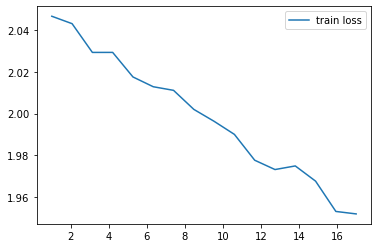

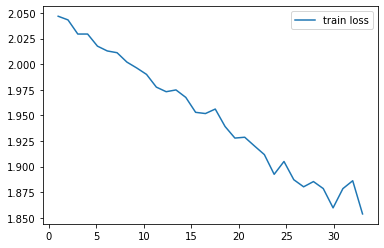

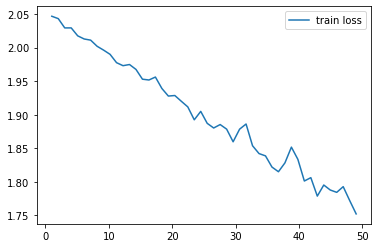

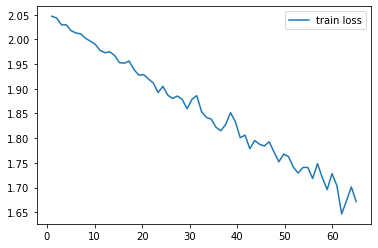

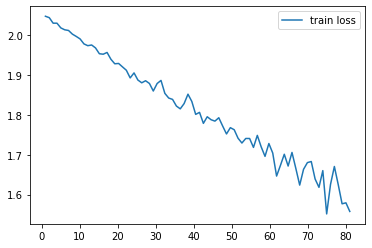

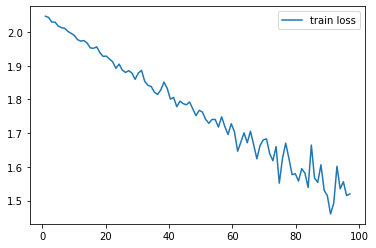

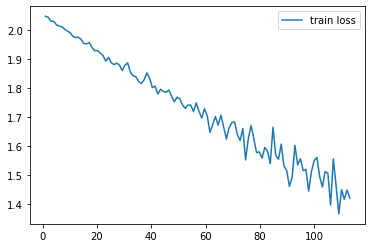

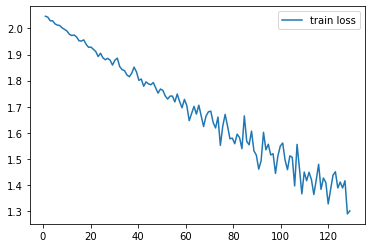

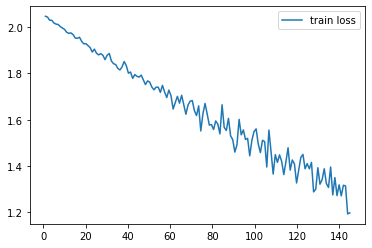

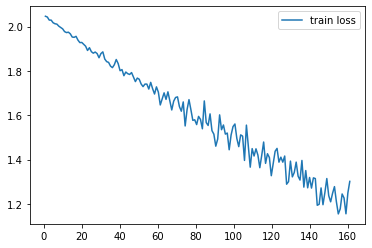

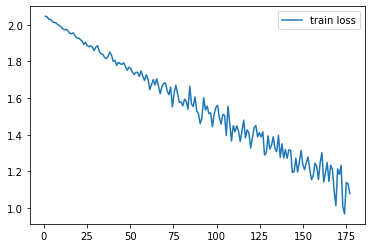

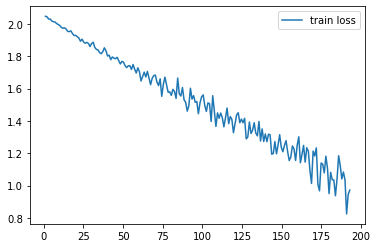

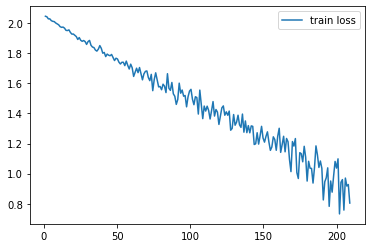

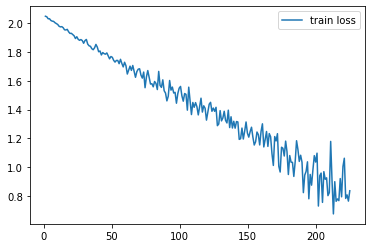

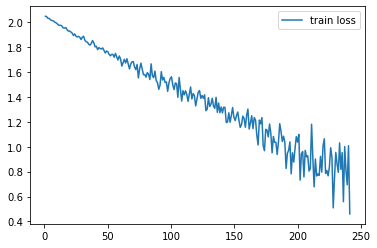

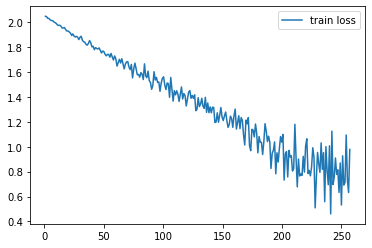

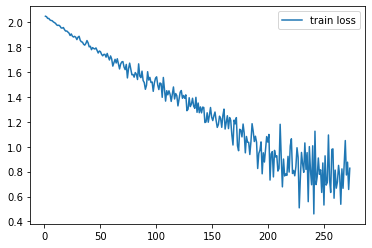

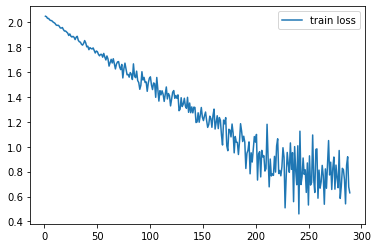

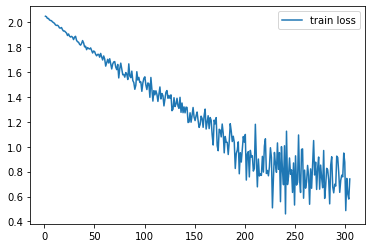

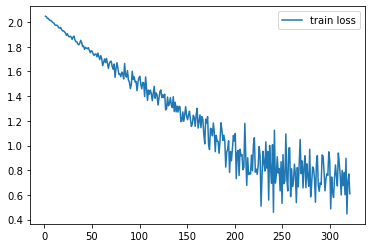

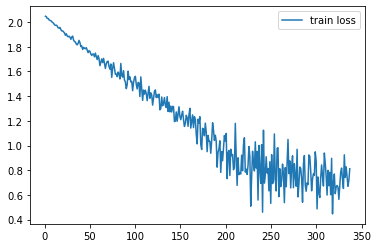

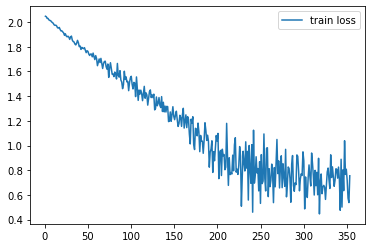

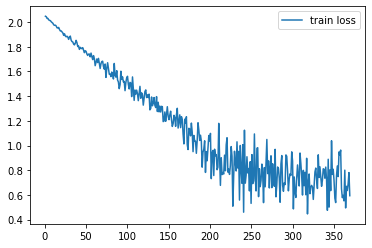

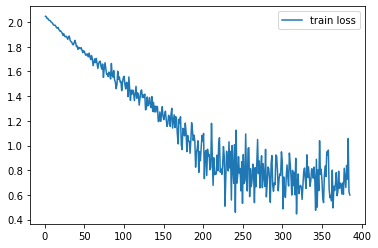

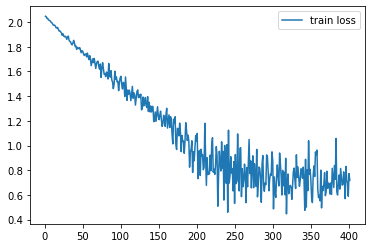

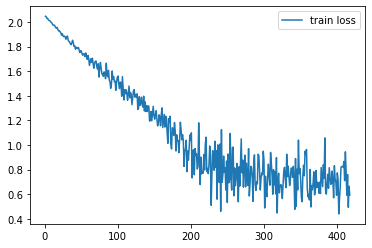

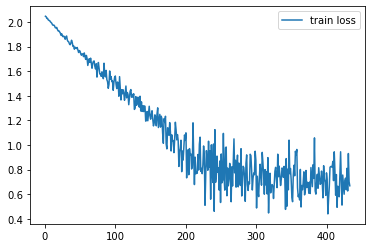

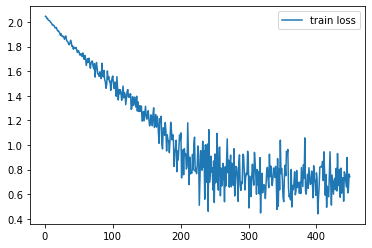

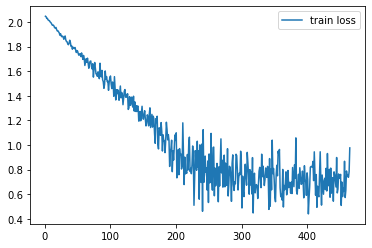

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np

train_dataset = EmotionDataSet(root = "F:/downloads/情绪识别/train",
                                transform = transforms.ToTensor(), limit = 1000)

model = EmotionNet()

lr = 0.01

opt = optim.SGD(params = model.parameters(), lr = lr)

loss_fn = nn.CrossEntropyLoss()

epochs = 32

batch_size = 64

train_loss_list = []

train_dl = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        train_loss_list.append(loss.item())
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    x = np.linspace(1, len(train_loss_list)+1, len(train_loss_list))
    plt.plot(x, train_loss_list, label = 'train loss')
    plt.legend()
    plt.show()


## Test

In [ ]:
test_dataset = EmotionDataSet(root="F:/downloads/情绪识别/train",
                                     transform = transforms.ToTensor(), limit = 1000)

print(test_dataset[0])
test_loss_list = []
ok_count = 0
print(len(test_dataset))
    
with torch.no_grad():
    for i in range(len(test_dataset)):
        x, label = test_dataset[i]
        
        pred = model(x.reshape(-1,1,48,48))
        
        max_index = torch.argmax(pred)
        if label == max_index:
            ok_count = ok_count + 1
        loss = loss_fn(pred, torch.tensor([label]))
        test_loss_list.append(loss.item())
    print(f"accuracy: {ok_count}/{len(test_dataset)}")
